In [15]:
import tensorflow as tf
from keras.layers import (
    Dense,
    Input,
    GlobalAveragePooling2D,
    Dropout,
    BatchNormalization,
    UpSampling2D,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Concatenate,
)
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.models import Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow import keras

# import tensorflow_model_optimization as tfmot
from keras import backend as K
from tqdm import tqdm
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
from module.const import *
from module import func, loss
import random

# データセット作成

In [16]:
# データセット
x_train = []
y_train = []
x_test = []
y_test = []
x_valid = []
y_valid = []
semantic_label_size = INPUT_SIZE
trans_lst = []
center = (INPUT_SIZE[0] / 2, INPUT_SIZE[1] / 2)
scale = 1.0
for i in [theta for theta in range(0, 180, 30)]:
    trans_lst.append(cv2.getRotationMatrix2D(center, i, scale))

    # for dir in ["train", "valid"]:
dataset = []
for path in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, path)
    with h5py.File(path, "r") as f:
        img = f["img"][:]
        label = f["label"][:]
    dataset.append((img, label))
random_idx = list(range(0, len(dataset)))

# データをランダムに取得するためのインデックス
random.shuffle(random_idx)
# データ取得。データ数が少ないため、auguentationを行う。回転、反転、明るさ調整を行い、学習データに追加。
positive_count = 0
for i, idx in enumerate(tqdm(random_idx)):
    img, label = dataset[idx]
    if i < len(random_idx) * 0.9:
        if np.sum(label) ==0:
            continue
        # else:
        #     continue
        for trans in trans_lst:
            img_trans = cv2.warpAffine(img, trans, semantic_label_size)
            label_trans = cv2.warpAffine(label, trans, semantic_label_size)
            img_trans = func.augment_brightness(img_trans)
            x_train.append(img_trans)
            y_train.append(cv2.resize(label_trans, semantic_label_size))
            img_trans = np.fliplr(img_trans)
            img_trans = func.augment_brightness(img_trans)
            x_train.append(img_trans)
            y_train.append(cv2.resize(np.fliplr(label_trans), semantic_label_size))
        # img_trans = img
        # img_trans = func.augment_brightness(img_trans)
        # x_train.append(img_trans)
        # y_train.append(cv2.resize(label, semantic_label_size))
        # img_trans = np.fliplr(img_trans)
        # img_trans = func.augment_brightness(img_trans)
        # x_train.append(img_trans)
        # y_train.append(cv2.resize(np.fliplr(label), semantic_label_size))
    else:
        x_valid.append(img)
        y_valid.append(cv2.resize(label, semantic_label_size))

100%|██████████| 8543/8543 [00:49<00:00, 173.74it/s] 


45096 854


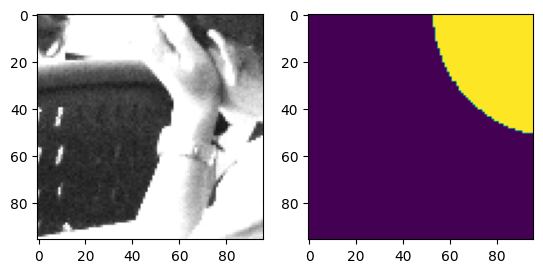

In [18]:
print(len(x_train), len(x_valid))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.subplot(1, 2, 2)
plt.imshow(y_train[0])
plt.show()

In [19]:

x_train = np.array(x_train) / 255
y_train = np.array(y_train)
x_test = np.array(x_test) / 255
y_test = np.array(y_test)
x_valid = np.array(x_valid) / 255
y_valid = np.array(y_valid)

# モデルの定義

In [5]:

mobilenet = MobileNetV2(
    input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL),
    include_top=False,
    alpha=ALPHA,
    # weights="imagenet",
    weights=None,
)
mobilenet.summary()
complessed_mobilenet = Model(
    inputs=mobilenet.input, outputs=mobilenet.get_layer("block_6_expand_relu").output
)
for layer in complessed_mobilenet.layers:
    # layer.trainable = False
    layer.trainable = True


semantic_model= tf.keras.models.Sequential(
    [
        complessed_mobilenet,
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        Conv2D(
            filters=1,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="sigmoid",
        ),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"), # 24
        Conv2D(
            filters=64,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"),# 48
        Conv2D(
            filters=32,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="relu",
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.UpSampling2D(size=(2,2), interpolation="bilinear"),# 96
        Conv2D(
            filters=1,
            kernel_size=1,
            strides=1,
            padding="same",
            activation="sigmoid",
        ),]

)

semantic_model.summary()

Model: "mobilenetv2_0.75_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 24)   648         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 24)   96          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 24)   0           ['bn_Conv1[0][0]']               
                                                                                

# 学習

In [6]:

def weighted_focal_Loss(targets, inputs, beta=0.4, smooth=1e-6):
    # targets = targets.astye('float')
    # flatten label and prediction tensors
    # tf_show(inputs[0])
    batch = len(inputs)
    targets = tf.cast(targets, dtype=tf.float32)
    # inputs = K.softmax(inputs, axis=-1)
    inputs = tf.expand_dims(inputs, axis=-1)
    # inputs = MaxPooling2D(pool_size=(2, 2))(inputs)
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = tf.reduce_sum(inputs * targets)
    precision = intersection / (K.sum(inputs) + smooth)
    recall = intersection / (K.sum(targets) + smooth)
    f = ((1 + beta**2) * precision * recall + smooth) / (
        beta**2 * precision + recall + smooth
    )
    return 1 - f

semantic_model.compile(
    # loss=loss.DiceLoss,
    loss=weighted_focal_Loss,
    optimizer=Adam(learning_rate=0.001),
    metrics=[loss.IoU],
)

semantic_model.fit(
    x_train,
    y_train,
    batch_size=36,
    epochs=50,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
1263/1263 [==============================] - 36s 24ms/step - loss: 0.4900 - IoU: 0.2728 - val_loss: 0.9999 - val_IoU: 1.0768e-05
Epoch 2/50
1263/1263 [==============================] - 30s 23ms/step - loss: 0.3986 - IoU: 0.3025 - val_loss: 0.9999 - val_IoU: 3.6455e-07
Epoch 3/50
1263/1263 [==============================] - 29s 23ms/step - loss: 0.3589 - IoU: 0.3258 - val_loss: 0.8633 - val_IoU: 0.0251
Epoch 4/50
1263/1263 [==============================] - 30s 23ms/step - loss: 0.3335 - IoU: 0.3442 - val_loss: 0.3824 - val_IoU: 0.2870
Epoch 5/50
1263/1263 [==============================] - 30s 23ms/step - loss: 0.3188 - IoU: 0.3569 - val_loss: 0.4465 - val_IoU: 0.2950
Epoch 6/50
1263/1263 [==============================] - 31s 24ms/step - loss: 0.3057 - IoU: 0.3665 - val_loss: 0.4287 - val_IoU: 0.3233
Epoch 7/50
1263/1263 [==============================] - 30s 24ms/step - loss: 0.2998 - IoU: 0.3722 - val_loss: 0.7223 - val_IoU: 0.2152
Epoch 8/50
1263/1263 [==================

# テスト

In [7]:
import shutil
test_img_lst = os.listdir("test")
test_result_dir = "test_result"
if os.path.exists(test_result_dir):
    shutil.rmtree(test_result_dir)
os.mkdir(test_result_dir)

In [8]:

for i, img_name in enumerate(test_img_lst):
    img_path = os.path.join("test", img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    pred = semantic_model.predict(img)
    pred = np.squeeze(pred)
    pred = np.where(pred > 0.5, 1, 0)
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.subplot(1, 2, 2)
    plt.imshow(pred)
    plt.savefig(os.path.join(test_result_dir, img_name))
    plt.close()

# モデルの変換
### 粗いセグメンテーションを実装するために、モデルを途中でちょん切る

In [9]:
def get_name_spresense_output_layer(model, idx_ketu):
    layer_name = model.layers[idx_ketu].name
    return layer_name

spresense_output_layer_name = get_name_spresense_output_layer(semantic_model, 5)
spresense_output_layer_name

'conv2d_2'

In [10]:

semantic_model.summary()
spresense_model = Model(
    inputs=semantic_model.input, outputs=semantic_model.get_layer(spresense_output_layer_name).output
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 12, 12, 144)       48928     
                                                                 
 conv2d (Conv2D)             (None, 12, 12, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        1056      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 1)         3

In [11]:

test_sprit_result_dir = "test_sprit_result" 
if os.path.exists(test_sprit_result_dir):
    shutil.rmtree(test_sprit_result_dir)
os.mkdir(test_sprit_result_dir)
for img_name in test_img_lst[::-1 ]:
    img_path = os.path.join("test", img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, INPUT_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    pred = spresense_model.predict(img)
    pred = np.squeeze(pred)
    # pred_stats = scipy.stats.describe(pred, axis=None)
    # mask_pred = np.where(pred >0.9, 1, 0)
    plt.subplot(2, 4, 1)
    plt.imshow(img[0])
    plt.title('image')
    plt.subplot(2, 4, 2)
    plt.imshow(pred, vmin=0, vmax=1)
    plt.title('pred')
    for i, rate in enumerate([0.9, 0.8, 0.7, 0.6, 0.5]):
        mask_pred = np.where(pred >rate, 1, 0)
        plt.subplot(2, 4, i+3)
        plt.imshow(mask_pred)
        plt.title('pred_mask(>{})'.format(rate))
    # cbar = plt.colorbar(pred, ax=plt.gca())
    # cbar.set_label('Colorbar Label')  # カラーバーのラベルを設定
    # plt.show()
    plt.tight_layout()
    plt.savefig(os.path.join(test_sprit_result_dir, img_name))
    plt.close()

# spresense用にモデル変換

In [12]:

if os.path.exists(MODEL_DIR) == False:
    os.mkdir(MODEL_DIR)
spresense_model.save(FULL_MODEL_PATH)
conveter = tf.lite.TFLiteConverter.from_keras_model(spresense_model)
tflite_model = conveter.convert()
float_model_size = len(tflite_model) / 1024 / 1024
print(f"float model size: {float_model_size} MB")
open(TFLITE_MODEL_PATH, "wb").write(tflite_model)


import binascii


def convert_to_c_array(bytes) -> str:
    hexstr = binascii.hexlify(bytes).decode("UTF-8")
    hexstr = hexstr.upper()
    array = ["0x" + hexstr[i : i + 2] for i in range(0, len(hexstr), 2)]
    array = [array[i : i + 10] for i in range(0, len(array), 10)]
    return ",\n  ".join([", ".join(e) for e in array])


tflite_binary = open(TFLITE_MODEL_PATH, "rb").read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = (
    "const unsigned char model_tflite[] = {\n  "
    + ascii_bytes
    + "\n};\nunsigned int model_tflite_len = "
    + str(len(tflite_binary))
    + ";"
)
# print(c_file)
open(HEADER_MODEL_PATH, "w").write(header_file)
open(SPRESENSE_HEADER_MODEL_PATH, "w").write(header_file)

INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmpbi7mh4rp\assets
float model size: 0.20491790771484375 MB


1332288

In [13]:
print("--------start quantization--------")


def representative_dataset_gen():
    for i in range(len(x_valid)):
        input_image = tf.cast(x_valid[i], tf.float32)
        input_image = tf.reshape(
            input_image, [1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL]
        )
        yield ([input_image])


converter = tf.lite.TFLiteConverter.from_keras_model(spresense_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_quant_model_path = os.path.join(MODEL_DIR, "model_quant.tflite")
with open(tflite_quant_model_path, "wb") as f:
    f.write(tflite_quant_model)
spresense_quant_model_path = os.path.join(MODEL_DIR, "spresense_model_quant.h")
tflite_binary = open(tflite_quant_model_path, "rb").read()
ascii_bytes = convert_to_c_array(tflite_binary)
header_file = (
    "const unsigned char model_tflite[] = {\n  "
    + ascii_bytes
    + "\n};\nunsigned int model_tflite_len = "
    + str(len(tflite_binary))
    + ";"
)

open(HEADER_QUANT_MODEL_PATH, "w").write(header_file)
open(SPRESENSE_HEADER_QUANT_MODEL_PATH, "w").write(header_file)


--------start quantization--------


INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmp0frf_y0e\assets


INFO:tensorflow:Assets written to: C:\Users\oosim\AppData\Local\Temp\tmp0frf_y0e\assets
c:\Users\oosim\Anaconda3\envs\fuc\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


714024

  0%|          | 0/59 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'test_result_quant\\0.png'

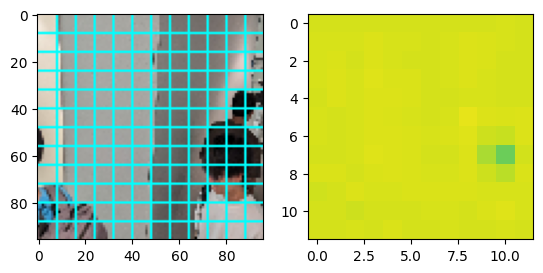

In [14]:
class TFLitePredictor:
    def __init__(self, model_path):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def __call__(self, input_data):
        input_data = input_data.astype(np.float32)
        self.interpreter.set_tensor(self.input_details[0]["index"], input_data)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]["index"])
        return output_data


if 
interpreter = TFLitePredictor(TFLITE_MODEL_PATH)
imgs = os.listdir(TEST_DIR)
imgs = imgs[::-1]
count = 0
for i, filename in enumerate(tqdm(imgs)):
    img = cv2.imread(os.path.join(TEST_DIR, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    splited_img_lst = func.split_img(img)
    for splited_img in splited_img_lst:
        splited_img = cv2.resize(splited_img, INPUT_SIZE)
        splited_img = np.array([splited_img]) / 255
        pred = interpreter(splited_img)
        splited_img = func.draw_line(splited_img[0])
        splited_img = (splited_img * 255).astype(np.uint8)
        plt.subplot(1, 2, 1)
        plt.imshow(splited_img)
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], vmin=0, vmax=1)
        save_path = os.path.join(TEST_SAVE_DIR, f"{count}.png")
        plt.savefig(save_path)
        plt.close()
        count += 1